## Spatial performance analysis across parameter space (Figures 4-5)

Evaluate C2ST at 400 grid points to reveal spatial degradation patterns and radial trends.

In [8]:
# ABOUTME: Spatial analysis (heatmaps + radial distance) for 2D toy inference task
# ABOUTME: Analyzes C2ST performance across parameter space using grid and circle evaluators

import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [9]:
from toolbox.imports import *
from toolbox.distributions import TailedUniform, IndependentTailedUniform
from toolbox.evaluators import GridEvaluator, CircleEvaluator

### Load trained posterior ensembles

In [10]:
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/toy-2-dim-models/uniform/posterior.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/tailed-uniform-sbi/toy-2-dim-models/taileduniform/posterior.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)

In [11]:
n_simulations = 4000
n_posterior_samples = 2000

# Parameters ranges
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Task setup
task = GaussianLinear(
    dim=2, prior_scale=param_1_width/2
)
simulator = task.get_simulator()

### Create 20×20 grid of test points (400 total)
- Uniform grid spans entire parameter space to systematically sample all regions.
- Goal is to evaluate posteriors at all grid points

In [12]:
n_points_per_dim = 20
rect_evaluator = GridEvaluator(simulator, param_ranges, task)

posterior_dict = {
    'Uniform': posterior_ensemble_old,
    'Tailed-Uniform': posterior_ensemble
}

test_points = rect_evaluator.create_test_points(n_points_per_dim)

In [13]:
results = rect_evaluator.evaluate_all(posterior_dict, test_points, n_posterior_samples)

Tailed-Uniform: 100%|██████████| 400/400 [00:18<00:00, 22.22it/s]


In [14]:
c2st_grid = rect_evaluator.compute_c2st_grid(results, n_points_per_dim)

### Generate C2ST heatmaps (Figure 4)

Uniform shows blue boundary degradation; TailedUniform maintains orange uniformity.

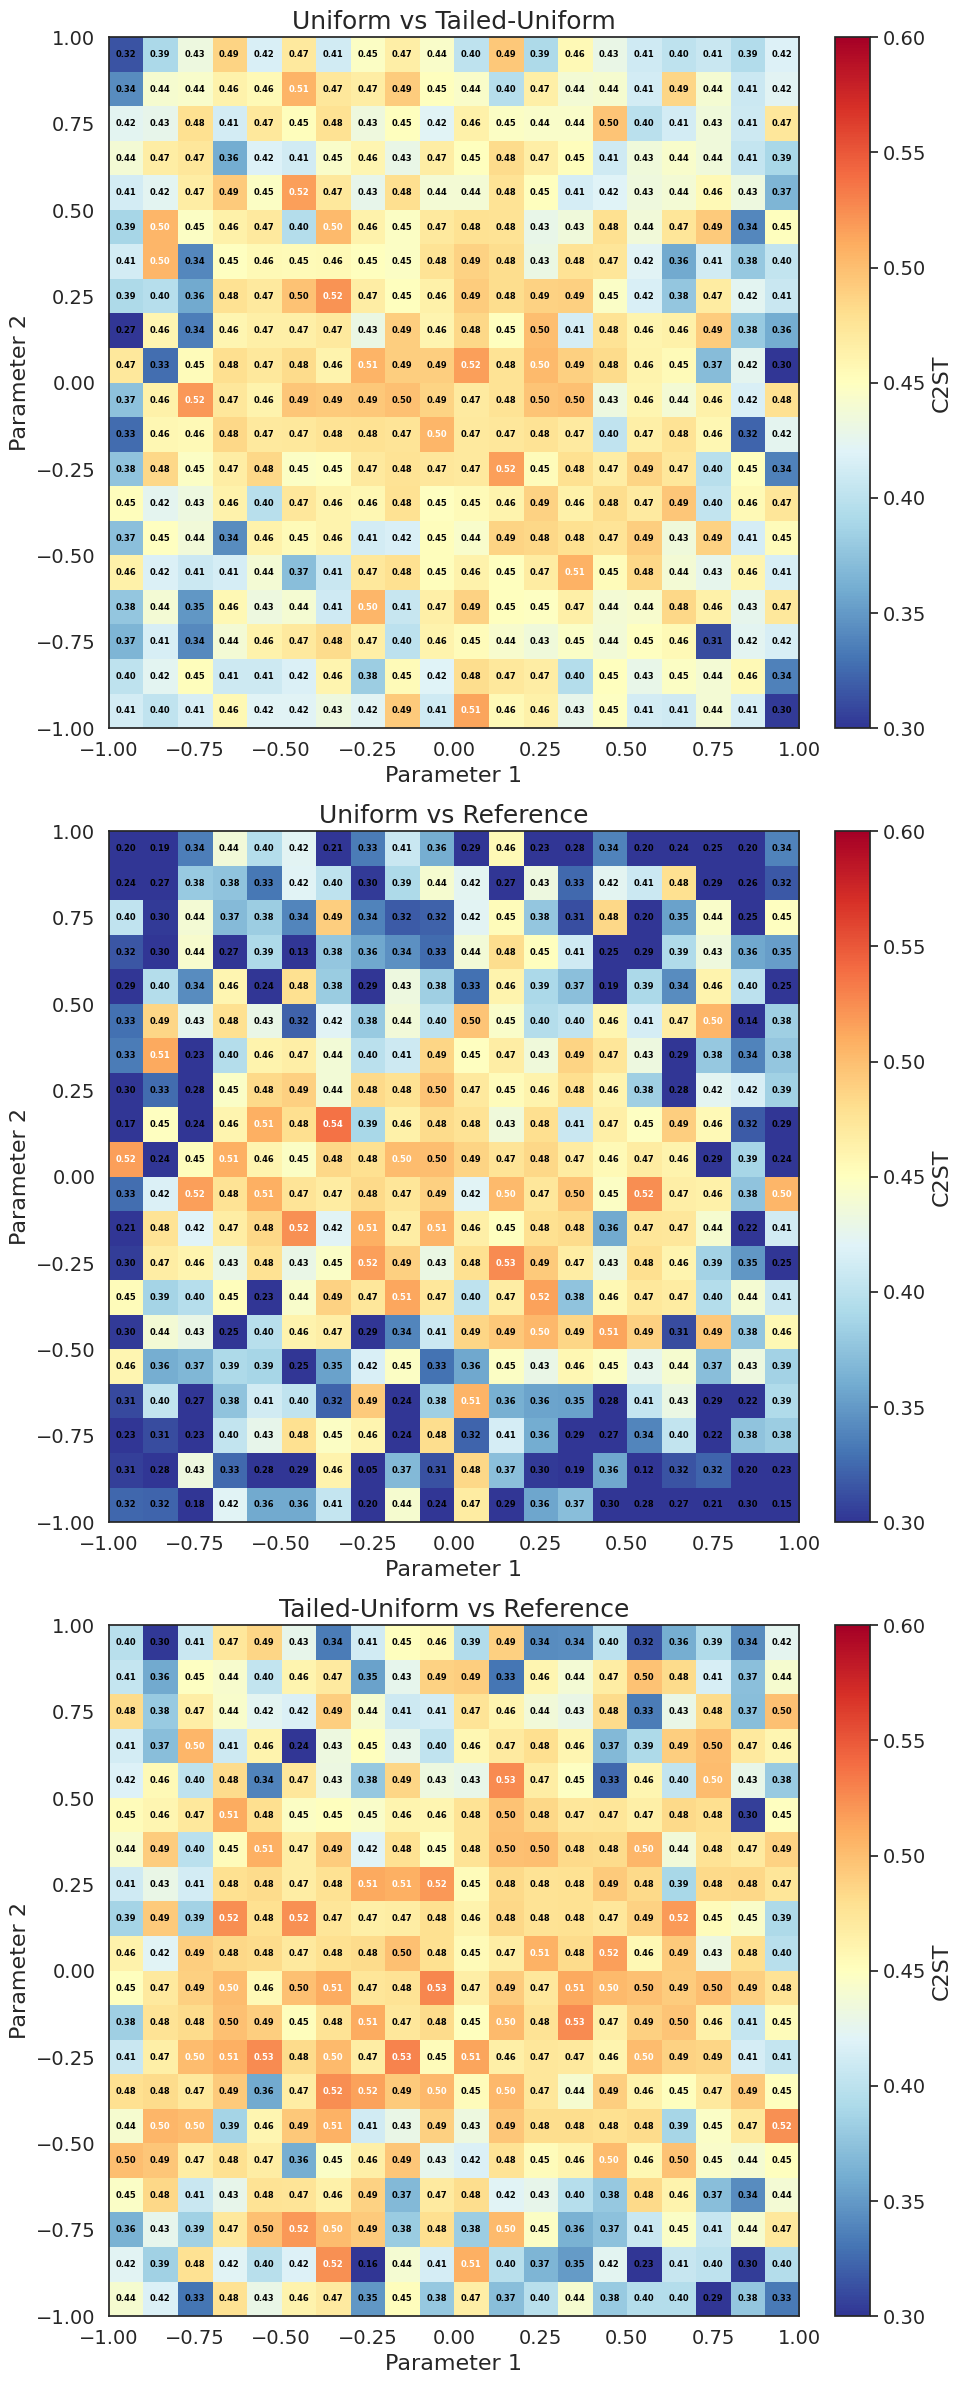

In [15]:
rect_evaluator.plot_c2st_grid(c2st_grid=c2st_grid, n_points_per_dim=n_points_per_dim)

### Radial evaluation

Exploit spherical symmetry by binning points by distance from center.

In [16]:
evaluator = CircleEvaluator(simulator, param_ranges, task)
posterior_dict = {
    'Uniform': posterior_ensemble_old,
    'TailedUniform': posterior_ensemble
}

- **Generate test points along radial shells**

In [17]:
test_points, radii = evaluator.create_test_points()

- **Evaluate and aggregate C2ST by radius:** we average C2ST within radial bins to reveal distance-dependent trends.

In [19]:
results = evaluator.evaluate_all(posterior_dict, test_points, n_posterior_samples)
c2st_data = evaluator.compute_c2st_by_radius(results, radii)

TailedUniform: 100%|██████████| 361/361 [00:12<00:00, 28.84it/s]


### Plot C2ST vs radius (Figure 5)

Shows Uniform degrades near boundaries while TailedUniform remains robust.

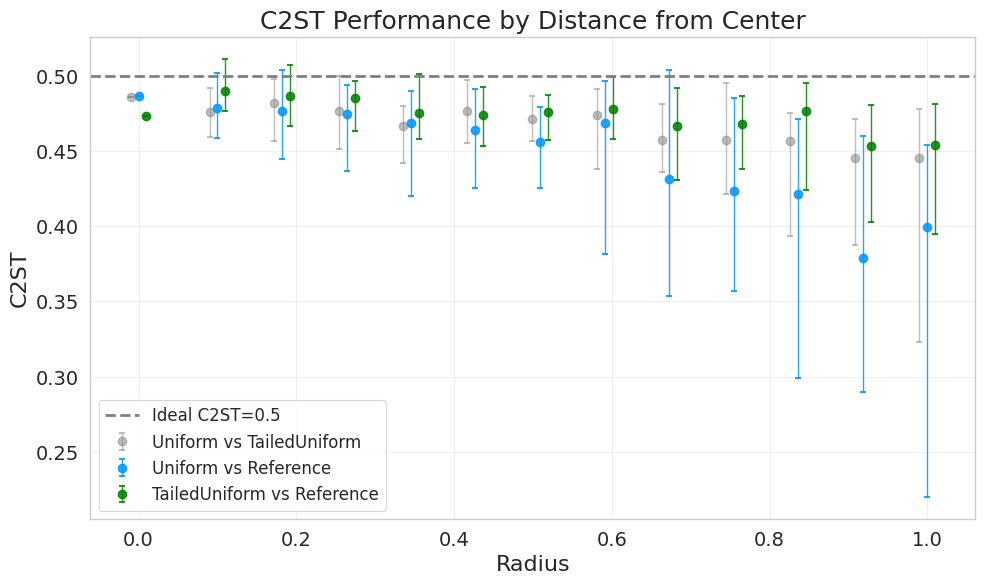

In [20]:
sns.set(style="whitegrid", context="paper", font_scale=1.2)
evaluator.plot_c2st_by_radius(c2st_data)